In [27]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import random

# for easier reading np
np.set_printoptions(precision=3,suppress=True)

# Data

In [28]:
# Prepare the data
def to1hot(labels):
    """Converts an array of class labels into their 1hot encodings. 
    Assumes that there are at most 3 classes."""
    return torch.eye(3)[labels]

class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

from sklearn import datasets
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Split into train/test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Normalize features
mu = X_train.mean(0, keepdims=True)
std = X_train.std(0, keepdims=True)
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std

db_train = Dataset(X_train, y_train)
db_test = Dataset(X_test, y_test)
print(len(db_train), db_train[0])

120 (array([-1.118, -0.088, -1.342, -1.305]), 0)


X_batch torch.Size([50, 4])
y_batch torch.Size([50])


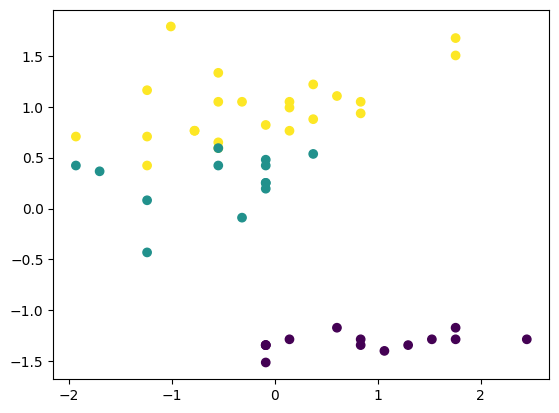

In [29]:
# Reading the dataset
def data_iter(batch_size, db):
    num_examples = len(db)
    
    # The examples are read at random, in no particular order
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        X, Y = [], []
        for j in indices[i:i + batch_size]:
            x, lbl = db[j]

            # Process image
            x = torch.from_numpy(x).float()
            lbl = torch.tensor(lbl).long()
            
            X.append(x), Y.append(lbl)
        yield torch.stack(X), torch.stack(Y)

# Check data reader
for X_batch, y_batch in data_iter(batch_size=50, db=db_train):
    print('X_batch', X_batch.shape)
    print('y_batch', y_batch.shape)
    plt.scatter(X_batch[:, 1].numpy(), X_batch[:, 2].numpy(), c=y_batch.numpy())
    break

# Model

In [30]:
# Define Model
from torch import nn

class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=30, num_classes=3, num_layers=2):
        super(DNN, self).__init__()

        # Define layers
        layers = [nn.Linear(input_dim, hidden_dim)]
        for i in range(1, num_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, num_classes))
        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
        
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                x = self.relu(layer(x))
            else:
                # Do not apply relu to the last layer
                x = layer(x)
        return x

# Check model
model = DNN(input_dim=4, num_classes=3, hidden_dim=30, num_layers=12)
for X_batch, y_batch in data_iter(batch_size=8, db=db_train):
    print('X_batch', X_batch.shape)
    out_batch = model(X_batch)
    print('out_batch', out_batch.shape, out_batch)
    break

X_batch torch.Size([8, 4])
out_batch torch.Size([8, 3]) tensor([[-0.1068,  0.0654, -0.0852],
        [-0.1068,  0.0654, -0.0852],
        [-0.1068,  0.0654, -0.0852],
        [-0.1068,  0.0654, -0.0852],
        [-0.1068,  0.0654, -0.0852],
        [-0.1068,  0.0654, -0.0852],
        [-0.1068,  0.0654, -0.0852],
        [-0.1068,  0.0654, -0.0852]], grad_fn=<AddmmBackward0>)


# Training

Start training
Epoch 10: Train Loss 1.104 Test Accuracy 0.335
Epoch 20: Train Loss 1.101 Test Accuracy 0.335
Epoch 30: Train Loss 1.101 Test Accuracy 0.330
Epoch 40: Train Loss 1.100 Test Accuracy 0.330
Epoch 50: Train Loss 1.100 Test Accuracy 0.339
Epoch 60: Train Loss 1.099 Test Accuracy 0.335
Epoch 70: Train Loss 1.099 Test Accuracy 0.330
Epoch 80: Train Loss 1.099 Test Accuracy 0.339
Epoch 90: Train Loss 1.100 Test Accuracy 0.344
Epoch 100: Train Loss 1.101 Test Accuracy 0.339
Epoch 110: Train Loss 1.101 Test Accuracy 0.335
Epoch 120: Train Loss 1.100 Test Accuracy 0.330
Epoch 130: Train Loss 1.100 Test Accuracy 0.335
Epoch 140: Train Loss 1.099 Test Accuracy 0.335
Epoch 150: Train Loss 1.100 Test Accuracy 0.321
Epoch 160: Train Loss 1.100 Test Accuracy 0.330
Epoch 170: Train Loss 1.100 Test Accuracy 0.339
Epoch 180: Train Loss 1.099 Test Accuracy 0.330
Epoch 190: Train Loss 1.100 Test Accuracy 0.330
Epoch 200: Train Loss 1.100 Test Accuracy 0.330

Start evaluation
CM = 
 [[ 0.  0.

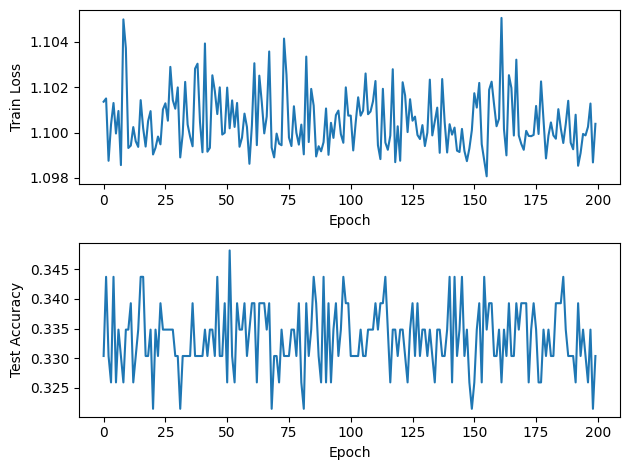

In [48]:
# Training
lr = 0.03
batch_size = 16
num_epochs = 200

model = DNN(input_dim=4, num_classes=3, hidden_dim=30, num_layers=5)
cross_entropy = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
accuracy = lambda y_hat, y: (y_hat.argmax(dim=1) == y).float().mean()

print("Start training")
all_losses, all_accuracies = [], []
for epoch in range(num_epochs):
    # Train for one epoch
    losses = []
    for X_batch, y_batch in data_iter(batch_size=batch_size, db=db_train):
        # Use model to compute predictions
        yhat = model(X_batch)
        l = cross_entropy(yhat, y_batch)  # Minibatch loss in `X_batch` and `y_batch`

        # Compute gradients by back propagation
        l.backward()

        # Update parameters using their gradient
        opt.step()
        opt.zero_grad()
        losses.append(l.detach().item())

    # Measure accuracy on the test set
    acc = []
    for X_batch, y_batch in data_iter(batch_size=16, db=db_test):
        yhat = model(X_batch)
        acc.append(accuracy(yhat, y_batch))

    all_losses.append(np.mean(losses))
    all_accuracies.append(np.mean(acc))
    
    if (epoch+1) % 10 == 0:
        # print(yhat)
        print(f"Epoch {epoch+1}: Train Loss {np.mean(losses):.3f} Test Accuracy {np.mean(acc):.3f}", flush=True)

# Evaluation
print("\nStart evaluation")
with torch.no_grad():
    yhat, y = [], []
    for X_batch, y_batch in data_iter(batch_size=16, db=db_test):
        yhat.append(model(X_batch))
        y.append(y_batch)

yhat = torch.cat(yhat, dim=0).argmax(dim=1)
y = torch.cat(y, dim=0)
cm = to1hot(y).T@to1hot(yhat)
print('CM = \n', cm.numpy())

plt.subplot(2, 1, 1)
plt.plot(all_losses)
plt.ylabel('Train Loss');
plt.xlabel('Epoch');
plt.subplot(2, 1, 2)
plt.plot(all_accuracies)
plt.ylabel('Test Accuracy');
plt.xlabel('Epoch');
plt.tight_layout()
plt.show()

##### Question 1-a

Around 30 Epoch were required to acheive convergance

##### Question 1-b

When we increase the number of layers the gradient going back up those layer becomes too small to make any meaningful affects

##### Question 1-c

In [50]:
# Define Model
from torch import nn

class Residual_DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=30, num_classes=3, num_layers=2):
        super(Residual_DNN, self).__init__()
        
        # Define layers
        layers = [nn.Linear(input_dim, hidden_dim)]
        for i in range(1, num_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, num_classes))
        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
        
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i > 0 and i < len(self.layers) - 1:  # Skip input and final layer
                x = x + self.relu(layer(x))  # Residual connection
            else:
                x = layer(x)  # No residual for input and final layer
        return x

# Check model
model = Residual_DNN(input_dim=4, num_classes=3, hidden_dim=30, num_layers=12)
for X_batch, y_batch in data_iter(batch_size=8, db=db_train):
    print('X_batch', X_batch.shape)
    out_batch = model(X_batch)
    print('out_batch', out_batch.shape, out_batch)
    break

X_batch torch.Size([8, 4])
out_batch torch.Size([8, 3]) tensor([[-0.0014,  0.0385, -0.1888],
        [-0.0018,  0.0373, -0.1877],
        [-0.0020,  0.0369, -0.1873],
        [-0.0016,  0.0386, -0.1886],
        [-0.0017,  0.0389, -0.1892],
        [-0.0029,  0.0366, -0.1860],
        [-0.0018,  0.0387, -0.1887],
        [-0.0020,  0.0386, -0.1886]], grad_fn=<AddmmBackward0>)


Not all layers can have residual connection becasue the dimension of the input and output layers are not the same as hidden layers

##### Question 1-d

Start training
Epoch 10: Train Loss 0.054 Test Accuracy 0.902
Epoch 20: Train Loss 0.008 Test Accuracy 0.897
Epoch 30: Train Loss 0.050 Test Accuracy 0.902
Epoch 40: Train Loss 0.002 Test Accuracy 0.906
Epoch 50: Train Loss 0.003 Test Accuracy 0.902
Epoch 60: Train Loss 0.001 Test Accuracy 0.897
Epoch 70: Train Loss 0.001 Test Accuracy 0.902
Epoch 80: Train Loss 0.000 Test Accuracy 0.902
Epoch 90: Train Loss 0.000 Test Accuracy 0.893
Epoch 100: Train Loss 0.000 Test Accuracy 0.902
Epoch 110: Train Loss 0.000 Test Accuracy 0.906
Epoch 120: Train Loss 0.000 Test Accuracy 0.897
Epoch 130: Train Loss 0.000 Test Accuracy 0.902
Epoch 140: Train Loss 0.000 Test Accuracy 0.902
Epoch 150: Train Loss 0.000 Test Accuracy 0.902
Epoch 160: Train Loss 0.000 Test Accuracy 0.906
Epoch 170: Train Loss 0.000 Test Accuracy 0.906
Epoch 180: Train Loss 0.000 Test Accuracy 0.906
Epoch 190: Train Loss 0.000 Test Accuracy 0.893
Epoch 200: Train Loss 0.000 Test Accuracy 0.897

Start evaluation
CM = 
 [[10.  0.

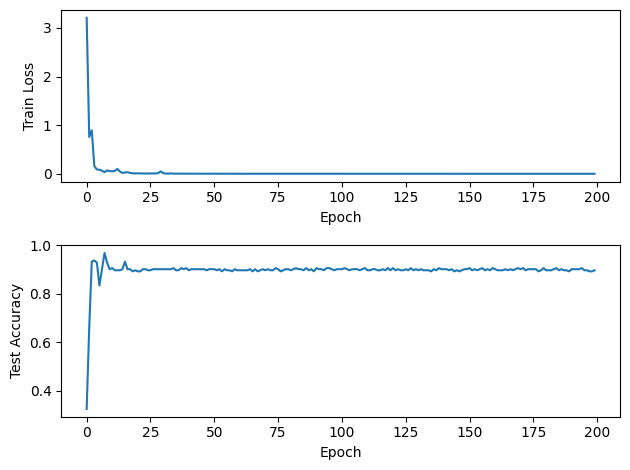

In [53]:
# Training
lr = 0.03
batch_size = 16
num_epochs = 200

model = Residual_DNN(input_dim=4, num_classes=3, hidden_dim=30, num_layers=100)
cross_entropy = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
accuracy = lambda y_hat, y: (y_hat.argmax(dim=1) == y).float().mean()

print("Start training")
all_losses, all_accuracies = [], []
for epoch in range(num_epochs):
    # Train for one epoch
    losses = []
    for X_batch, y_batch in data_iter(batch_size=batch_size, db=db_train):
        # Use model to compute predictions
        yhat = model(X_batch)
        l = cross_entropy(yhat, y_batch)  # Minibatch loss in `X_batch` and `y_batch`

        # Compute gradients by back propagation
        l.backward()

        # Update parameters using their gradient
        opt.step()
        opt.zero_grad()
        losses.append(l.detach().item())

    # Measure accuracy on the test set
    acc = []
    for X_batch, y_batch in data_iter(batch_size=16, db=db_test):
        yhat = model(X_batch)
        acc.append(accuracy(yhat, y_batch))

    all_losses.append(np.mean(losses))
    all_accuracies.append(np.mean(acc))
    
    if (epoch+1) % 10 == 0:
        # print(yhat)
        print(f"Epoch {epoch+1}: Train Loss {np.mean(losses):.3f} Test Accuracy {np.mean(acc):.3f}", flush=True)

# Evaluation
print("\nStart evaluation")
with torch.no_grad():
    yhat, y = [], []
    for X_batch, y_batch in data_iter(batch_size=16, db=db_test):
        yhat.append(model(X_batch))
        y.append(y_batch)

yhat = torch.cat(yhat, dim=0).argmax(dim=1)
y = torch.cat(y, dim=0)
cm = to1hot(y).T@to1hot(yhat)
print('CM = \n', cm.numpy())

plt.subplot(2, 1, 1)
plt.plot(all_losses)
plt.ylabel('Train Loss');
plt.xlabel('Epoch');
plt.subplot(2, 1, 2)
plt.plot(all_accuracies)
plt.ylabel('Test Accuracy');
plt.xlabel('Epoch');
plt.tight_layout()
plt.show()

All layer amounts perform similarly

##### Question 1-e

Residual connections help train deep neural networks because they mitigate the diminishing gradient problem, improve gradient flow, and make deeper models easier to optimize. That is why when we train with more layers the accuracy stays the same and the model is able to learn